# Second try of BERT fine-tuning 
* Fine-tune on 20 concatenated tweets level (author mini batches)
* Choose model that achieved highest score on the validation set
* Predict on author level depending on threshold 
* Get embeddings from fine-tuned model, add emoji2vec embeddings and indicator variables
* Try LR, SVM, and RF with an ablation study

# Author: David Dukić


## Import libraries

In [1]:
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForPreTraining,
    AdamW,
    BertConfig,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
)
import torch
from torch.utils.data import (
    TensorDataset,
    DataLoader,
    RandomSampler,
    SequentialSampler,
)
import torch.nn as nn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd
import numpy as np
import random
import emoji
from gensim.models.keyedvectors import KeyedVectors as kv
import pickle
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import re
from itertools import product
from collections import defaultdict

theme_bw = "theme_bw.mplstyle"
plt.style.use(theme_bw)
%matplotlib inline

path = "../"

/home/ddukic/.conda/envs/venv/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Define device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

## Get emoji vectors

In [3]:
e2v = kv.load_word2vec_format(path + "models/emoji2vec.bin", binary=True)

## Read dataframes

In [4]:
df_train = pd.read_csv(path + "dataset/train_clean.csv", encoding="utf-8", sep=";")
df_test = pd.read_csv(path + "dataset/test_clean.csv", encoding="utf-8", sep=";")

In [5]:
df_train.head()

author_id  \
0  a8e2397021acef98cc32729cbda96910   
1  a8e2397021acef98cc32729cbda96910   
2  a8e2397021acef98cc32729cbda96910   
3  a8e2397021acef98cc32729cbda96910   
4  a8e2397021acef98cc32729cbda96910   

                                               tweet  \
0           rt #user#: i fight my battles in silence   
1  rt #user#: because telling yo business to anot...   
2                                 #user# lmao on god   
3                       glad somebody said it  #url#   
4                    i know you fucking lying  #url#   

                                         tweet_clean  \
0              rt user i fight my battles in silence   
1  rt user because telling yo business to anotha ...   
2                                   user lmao on god   
3                          glad somebody said it url   
4                       i know you fucking lying url   

                                   tweet_clean_extra     emoji  rt  user  url  \
0                      i fight my battles in silence       NaN   1     1    0   
1  because telling yo business to anotha mf aint ...       NaN   1     1    0   
2                                        lmao on god       NaN   0     1    0   
3                              glad somebody said it      😂😂😂😂   0     0    1   
4                           i know you fucking lying  😂😂😂😭😭😭😭😭   0     0    1   

   hashtag  label  
0        0      0  
1        0      0  
2        0      0  
3        0      0  
4        0      0

In [6]:
df_test.head()

author_id  \
0  ed47e83208995121ef69c686aa16ba1c   
1  ed47e83208995121ef69c686aa16ba1c   
2  ed47e83208995121ef69c686aa16ba1c   
3  ed47e83208995121ef69c686aa16ba1c   
4  ed47e83208995121ef69c686aa16ba1c   

                                               tweet  \
0  rt #user#: gang of masked bandits steals anoth...   
1  rt #user#: texas is open. mississippi is open....   
2  rt #user#: with pandemic ending, people who ye...   
3  rt #user#: hernando farmers market vendor meet...   
4  rt #user#: i got home just in time to see my s...   

                                         tweet_clean  \
0  rt user gang of masked bandits steals another ...   
1  rt user texas is open mississippi is open when...   
2  rt user with pandemic ending people who yell a...   
3  rt user hernando farmers market vendor meeting...   
4  rt user i got home just in time to see my swee...   

                                   tweet_clean_extra emoji  rt  user  url  \
0  gang of masked bandits steals another few tril...   NaN   1     1    1   
1  texas is open mississippi is open when will oh...   NaN   1     1    0   
2  with pandemic ending people who yell at others...   NaN   1     1    0   
3      hernando farmers market vendor meeting hybrid   NaN   1     1    1   
4  i got home just in time to see my sweet little...   NaN   1     1    0   

   hashtag  label  
0        0      1  
1        0      1  
2        0      1  
3        0      1  
4        0      1

## Check tweet lengths (we will enlarge the dataset author-level-wise by merging 20 tweets of each author into a new data point)

In [7]:
pd.Series(df_train.tweet).str.split().str.len().sort_values(ascending=False).describe()

count    40000.000000
mean        12.114425
std          5.344403
min          2.000000
25%          8.000000
50%         12.000000
75%         16.000000
max         32.000000
Name: tweet, dtype: float64

# Use only originally cleaned dataframe

In [8]:
def create_clean_df(df):
    df_tweet = df.drop(["tweet_clean", "tweet_clean_extra"], axis=1)
    return {
        "original": df_tweet,
    }


df = {"train": create_clean_df(df_train), "test": create_clean_df(df_test)}

## Merge tweets

In [9]:
def merge_tweets(df, num_to_merge=20):
    df_tweet = (
        df.groupby(["author_id", df.index // num_to_merge], group_keys=False)
        .tweet.apply(lambda x: ". ".join(x))
        .reset_index()
        .drop(["level_1"], axis=1)
    )
    df_emoji = (
        df.fillna("")
        .groupby(["author_id", df.index // num_to_merge], group_keys=False)
        .emoji.apply(lambda x: "".join(x))
        .reset_index()
        .drop(["level_1"], axis=1)
    )
    df_label = (
        df.groupby(["author_id", df.index // num_to_merge], group_keys=False)
        .label.apply(lambda x: list(set(x))[0])
        .reset_index()
        .drop(["level_1"], axis=1)
    )
    df_tweet["emoji"] = df_emoji.emoji
    df_tweet["rt"] = df_tweet.tweet.apply(lambda x: 1 if re.search(r"\brt\b", x) else 0)
    df_tweet["url"] = df_tweet.tweet.apply(
        lambda x: 1 if re.search(r"\burl\b", x) else 0
    )
    df_tweet["hashtag"] = df_tweet.tweet.apply(
        lambda x: 1 if re.search(r"\bhashtag\b", x) else 0
    )
    df_tweet["label"] = df_label.label
    return df_tweet

In [10]:
df["train"]["original"] = merge_tweets(df["train"]["original"], num_to_merge=20)
df["test"]["original"] = merge_tweets(df["test"]["original"], num_to_merge=20)

## Check tweet lengths after merging to decide max number of tokens for BERT (300)

In [11]:
pd.Series(df["train"]["original"].tweet).str.split().str.len().sort_values(
    ascending=False
).describe()

count    2000.000000
mean      243.931000
std        41.167507
min       126.000000
25%       216.000000
50%       243.000000
75%       270.000000
max       449.000000
Name: tweet, dtype: float64

## Load and prepare BERT

In [12]:
tokenizer = transformers.BertTokenizer.from_pretrained(
    "bert-base-uncased", do_lower_case=True
)

bert_model = transformers.BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=True,
    output_hidden_states=True,
)

bert_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Define tokenization

In [13]:
def tokenize_tweets(df):
    input_ids = []
    attention_masks = []

    for tweet in df.tweet.values:
        encoded_dict = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            padding="max_length",
            max_length=300,
            return_attention_mask=True,
            truncation=True,
            return_tensors="pt",
        )
        input_ids.append(encoded_dict["input_ids"])
        attention_masks.append(encoded_dict["attention_mask"])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

## Load data set splits

In [14]:
def load_author_splits(split):
    with open(
        path + "final_dataset/" + split + "/" + split + "_author_id.txt", "r"
    ) as f:
        return [author.strip() for author in f.readlines()]


def filter_by_author_id(df_train, df_test):
    author_splits = {}

    for x in ["train", "valid", "test"]:
        author_splits[x] = load_author_splits(x)

    return {
        "train": df_train[df_train.author_id.isin(author_splits["train"])],
        "valid": df_train[df_train.author_id.isin(author_splits["valid"])],
        "test": df_test[df_test.author_id.isin(author_splits["test"])],
    }

## Prepare different data sets with split into train, valid, and test

In [15]:
original_splits = filter_by_author_id(df["train"]["original"], df["test"]["original"])

## Create dataloader using original splits

In [16]:
dataloader = {}

dataset_sizes = {}

for x in ["train", "valid", "test"]:
    dataframe_x = original_splits[x][["tweet", "label"]]
    input_ids, attention_masks = tokenize_tweets(dataframe_x)
    labels = torch.tensor(dataframe_x.label.values)
    dataset_x = TensorDataset(input_ids, attention_masks, labels)
    if x == "train":
        sampler = RandomSampler(dataset_x, generator=torch.Generator().manual_seed(42))
    else:
        sampler = SequentialSampler(dataset_x)
    dataloader[x] = DataLoader(dataset_x, sampler=sampler, batch_size=5)
    dataset_sizes[x] = len(dataframe_x)

## Evaluate model

## Predict on unseen data

In [54]:
def get_final_prediction(predictions, threshold=0.5):
    ones = 0

    for pred in predictions:
        if pred == 1:
            ones += 1

    ones_p = ones / len(predictions)

    if ones_p >= threshold:
        return 1
    else:
        return 0


def evaluate(
    model,
    criterion,
    loader,
    return_loss=False,
    threshold=0.5,
    tweets_per_author=200 / 20,
):
    with torch.no_grad():
        model.eval()
        loss_test = 0
        y_pred_test = []
        y_test = []
        y_test_author = []
        y_pred_test_author = []

        tweet_counter = 0

        for batch in loader:
            batch_input_ids = batch[0].to(device)
            batch_attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            batch_size = batch_input_ids.size(0)

            y_test_author.extend(labels.cpu().numpy())

            outputs = model(batch_input_ids, batch_attention_mask)

            loss = criterion(outputs.logits, labels)

            loss_test += loss.item() * batch_size

            _, y_pred = torch.max(outputs.logits, 1)

            y_pred_test_author.extend(y_pred.cpu().numpy())

            tweet_counter += batch_size

            if tweet_counter == tweets_per_author:
                y_test.append(list(set(y_test_author))[0])
                y_pred_test.append(get_final_prediction(y_pred_test_author, threshold))
                y_test_author = []
                y_pred_test_author = []
                tweet_counter = 0

        if return_loss:
            return loss_test, y_test, y_pred_test
        else:
            return y_test, y_pred_test

## Define train function

In [155]:
def train(
    model,
    optimizer,
    criterion,
    scheduler,
    epoch_num,
    dataloader,
    dataset_sizes,
    max_epochs_no_improve_tolerate=20,
    threshold=0.5,
    tweets_per_author=200 / 20,
):

    best_model = copy.deepcopy(model.state_dict())

    losses_train = []
    losses_valid = []
    accuracies_train = []
    accuracies_valid = []

    epochs_no_improve_counter = 0
    max_accuracy_valid = 0

    for epoch in tqdm(range(epoch_num)):
        model.train()
        loss_train = 0

        y_train = []
        y_pred_train = []

        for batch in dataloader["train"]:
            batch_input_ids = batch[0].to(device)
            batch_attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            batch_size = batch_input_ids.size(0)

            y_train.extend(labels.cpu().numpy())

            model.zero_grad()
            optimizer.zero_grad()

            outputs = model(
                input_ids=batch_input_ids, attention_mask=batch_attention_mask
            )

            loss = criterion(outputs.logits, labels)

            loss_train += loss.item() * batch_size

            _, y_pred = torch.max(outputs.logits, 1)
            y_pred_train.extend(y_pred.cpu().numpy())

            loss.backward()

            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

        scheduler.step()

        accuracy_train = accuracy_score(y_train, y_pred_train)

        loss_valid, y_valid, y_pred_valid = evaluate(
            model,
            criterion,
            dataloader["valid"],
            return_loss=True,
            threshold=threshold,
            tweets_per_author=tweets_per_author,
        )

        accuracy_valid = accuracy_score(y_valid, y_pred_valid)

        print(
            "\nEpoch: ",
            epoch,
            "\t",
            "train loss: ",
            loss_train / dataset_sizes["train"],
        )
        print(
            "Epoch: ",
            epoch,
            "\t",
            "validation loss: ",
            loss_valid / dataset_sizes["valid"],
        )
        print("Epoch: ", epoch, "\t", "train accuracy: ", accuracy_train)
        print("Epoch: ", epoch, "\t", "validation accuracy: ", accuracy_valid)

        losses_train.append(loss_train / dataset_sizes["train"])
        losses_valid.append(loss_valid / dataset_sizes["valid"])
        accuracies_train.append(accuracy_train)
        accuracies_valid.append(accuracy_valid)

        if accuracy_valid > max_accuracy_valid:
            print("\n--------------------")
            print("Found better model!")
            print("--------------------")
            best_model = copy.deepcopy(model.state_dict())
            epochs_no_improve_counter = 0
            max_accuracy_valid = accuracy_valid
        else:
            epochs_no_improve_counter += 1
            if (
                epochs_no_improve_counter >= max_epochs_no_improve_tolerate
                and epoch > max_epochs_no_improve_tolerate
            ):
                print("Early stopping the training!")
                model.load_state_dict(best_model)
                return (
                    model,
                    losses_train,
                    losses_valid,
                    accuracies_train,
                    accuracies_valid,
                )

    model.load_state_dict(best_model)

    return model, losses_train, losses_valid, accuracies_train, accuracies_valid

## Prepare model and train

In [42]:
epoch_num = 200

# best lr=1e-7
# best thr=0.5
# best results:
"""
Precision: 0.6896551724137931
Recall: 0.8
F1: 0.7407407407407408
Accuracy: 0.72

These are scoring values on the test set for best fine-tuned BERT
"""

optimizer = AdamW(bert_model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=epoch_num
)

In [20]:
best_bert_model, losses_train, losses_valid, accuracies_train, accuracies_valid = train(
    bert_model,
    optimizer,
    criterion,
    scheduler,
    epoch_num,
    dataloader,
    dataset_sizes,
    threshold=0.5,
)

  0%|          | 1/200 [00:42<2:20:38, 42.40s/it]


Epoch:  0 	 train loss:  0.717987486521403
Epoch:  0 	 validation loss:  0.7023041850328445
Epoch:  0 	 train accuracy:  0.49733333333333335
Epoch:  0 	 validation accuracy:  0.5

--------------------
Found better model!
--------------------


  1%|          | 2/200 [01:24<2:19:08, 42.16s/it]


Epoch:  1 	 train loss:  0.6996736319859823
Epoch:  1 	 validation loss:  0.6942297625541687
Epoch:  1 	 train accuracy:  0.5153333333333333
Epoch:  1 	 validation accuracy:  0.52

--------------------
Found better model!
--------------------


  2%|▏         | 3/200 [02:06<2:18:23, 42.15s/it]


Epoch:  2 	 train loss:  0.6988274210691452
Epoch:  2 	 validation loss:  0.6914627546072006
Epoch:  2 	 train accuracy:  0.49866666666666665
Epoch:  2 	 validation accuracy:  0.52


  2%|▏         | 4/200 [02:49<2:18:08, 42.29s/it]


Epoch:  3 	 train loss:  0.6903857038418452
Epoch:  3 	 validation loss:  0.6890758979320526
Epoch:  3 	 train accuracy:  0.5306666666666666
Epoch:  3 	 validation accuracy:  0.58

--------------------
Found better model!
--------------------


  2%|▎         | 5/200 [03:31<2:18:08, 42.51s/it]


Epoch:  4 	 train loss:  0.6860815980037054
Epoch:  4 	 validation loss:  0.6868758660554886
Epoch:  4 	 train accuracy:  0.5333333333333333
Epoch:  4 	 validation accuracy:  0.58


  3%|▎         | 6/200 [04:14<2:17:56, 42.66s/it]


Epoch:  5 	 train loss:  0.6773871793349584
Epoch:  5 	 validation loss:  0.6843663948774338
Epoch:  5 	 train accuracy:  0.566
Epoch:  5 	 validation accuracy:  0.54


  4%|▎         | 7/200 [04:57<2:17:34, 42.77s/it]


Epoch:  6 	 train loss:  0.6828923714160919
Epoch:  6 	 validation loss:  0.682024405002594
Epoch:  6 	 train accuracy:  0.568
Epoch:  6 	 validation accuracy:  0.6

--------------------
Found better model!
--------------------


  4%|▍         | 8/200 [05:40<2:17:03, 42.83s/it]


Epoch:  7 	 train loss:  0.6800383826096853
Epoch:  7 	 validation loss:  0.6798941612243652
Epoch:  7 	 train accuracy:  0.56
Epoch:  7 	 validation accuracy:  0.6


  4%|▍         | 9/200 [06:23<2:16:37, 42.92s/it]


Epoch:  8 	 train loss:  0.6755562041203181
Epoch:  8 	 validation loss:  0.6781842222809792
Epoch:  8 	 train accuracy:  0.5693333333333334
Epoch:  8 	 validation accuracy:  0.6


  5%|▌         | 10/200 [07:07<2:16:06, 42.98s/it]


Epoch:  9 	 train loss:  0.6801700971523921
Epoch:  9 	 validation loss:  0.6752466452121735
Epoch:  9 	 train accuracy:  0.56
Epoch:  9 	 validation accuracy:  0.64

--------------------
Found better model!
--------------------


  6%|▌         | 11/200 [07:50<2:15:28, 43.01s/it]


Epoch:  10 	 train loss:  0.671265862385432
Epoch:  10 	 validation loss:  0.6726803520321846
Epoch:  10 	 train accuracy:  0.5806666666666667
Epoch:  10 	 validation accuracy:  0.62


  6%|▌         | 12/200 [08:33<2:14:52, 43.04s/it]


Epoch:  11 	 train loss:  0.6682379882534345
Epoch:  11 	 validation loss:  0.6709730365872383
Epoch:  11 	 train accuracy:  0.5933333333333334
Epoch:  11 	 validation accuracy:  0.62


  6%|▋         | 13/200 [09:16<2:14:12, 43.06s/it]


Epoch:  12 	 train loss:  0.6648128435015679
Epoch:  12 	 validation loss:  0.6684854990243911
Epoch:  12 	 train accuracy:  0.5813333333333334
Epoch:  12 	 validation accuracy:  0.64


  7%|▋         | 14/200 [09:59<2:13:34, 43.09s/it]


Epoch:  13 	 train loss:  0.6668445067604383
Epoch:  13 	 validation loss:  0.6673696440458298
Epoch:  13 	 train accuracy:  0.5926666666666667
Epoch:  13 	 validation accuracy:  0.66

--------------------
Found better model!
--------------------


  8%|▊         | 15/200 [10:42<2:12:53, 43.10s/it]


Epoch:  14 	 train loss:  0.6648317899306615
Epoch:  14 	 validation loss:  0.667857957482338
Epoch:  14 	 train accuracy:  0.5793333333333334
Epoch:  14 	 validation accuracy:  0.64


  8%|▊         | 16/200 [11:25<2:12:05, 43.08s/it]


Epoch:  15 	 train loss:  0.6576338497797648
Epoch:  15 	 validation loss:  0.6653502041101456
Epoch:  15 	 train accuracy:  0.612
Epoch:  15 	 validation accuracy:  0.64


  8%|▊         | 17/200 [12:08<2:11:35, 43.14s/it]


Epoch:  16 	 train loss:  0.6567085747917493
Epoch:  16 	 validation loss:  0.6628414568305016
Epoch:  16 	 train accuracy:  0.61
Epoch:  16 	 validation accuracy:  0.68

--------------------
Found better model!
--------------------


  9%|▉         | 18/200 [12:52<2:10:51, 43.14s/it]


Epoch:  17 	 train loss:  0.6554024753967921
Epoch:  17 	 validation loss:  0.6633874362707138
Epoch:  17 	 train accuracy:  0.6153333333333333
Epoch:  17 	 validation accuracy:  0.64


 10%|▉         | 19/200 [13:35<2:10:07, 43.13s/it]


Epoch:  18 	 train loss:  0.6477164428432782
Epoch:  18 	 validation loss:  0.6626204329729081
Epoch:  18 	 train accuracy:  0.6266666666666667
Epoch:  18 	 validation accuracy:  0.64


 10%|█         | 20/200 [14:18<2:09:24, 43.14s/it]


Epoch:  19 	 train loss:  0.6417873792846998
Epoch:  19 	 validation loss:  0.6609249985218049
Epoch:  19 	 train accuracy:  0.6433333333333333
Epoch:  19 	 validation accuracy:  0.68


 10%|█         | 21/200 [15:01<2:08:49, 43.18s/it]


Epoch:  20 	 train loss:  0.6390758875012398
Epoch:  20 	 validation loss:  0.658961777985096
Epoch:  20 	 train accuracy:  0.632
Epoch:  20 	 validation accuracy:  0.7

--------------------
Found better model!
--------------------


 11%|█         | 22/200 [15:44<2:08:09, 43.20s/it]


Epoch:  21 	 train loss:  0.6313051149249077
Epoch:  21 	 validation loss:  0.6599567195773125
Epoch:  21 	 train accuracy:  0.658
Epoch:  21 	 validation accuracy:  0.7


 12%|█▏        | 23/200 [16:28<2:07:28, 43.21s/it]


Epoch:  22 	 train loss:  0.6330532125631968
Epoch:  22 	 validation loss:  0.6563887163996697
Epoch:  22 	 train accuracy:  0.6386666666666667
Epoch:  22 	 validation accuracy:  0.7


 12%|█▏        | 24/200 [17:11<2:06:47, 43.22s/it]


Epoch:  23 	 train loss:  0.6268423281113307
Epoch:  23 	 validation loss:  0.6589546197652817
Epoch:  23 	 train accuracy:  0.6666666666666666
Epoch:  23 	 validation accuracy:  0.7


 12%|█▎        | 25/200 [17:54<2:06:07, 43.24s/it]


Epoch:  24 	 train loss:  0.6232543282707532
Epoch:  24 	 validation loss:  0.6543402400612831
Epoch:  24 	 train accuracy:  0.6626666666666666
Epoch:  24 	 validation accuracy:  0.7


 13%|█▎        | 26/200 [18:37<2:05:23, 43.24s/it]


Epoch:  25 	 train loss:  0.626297980248928
Epoch:  25 	 validation loss:  0.6532179361581802
Epoch:  25 	 train accuracy:  0.652
Epoch:  25 	 validation accuracy:  0.74

--------------------
Found better model!
--------------------


 14%|█▎        | 27/200 [19:21<2:04:38, 43.23s/it]


Epoch:  26 	 train loss:  0.6201005825400352
Epoch:  26 	 validation loss:  0.6535203716158867
Epoch:  26 	 train accuracy:  0.6673333333333333
Epoch:  26 	 validation accuracy:  0.66


 14%|█▍        | 28/200 [20:04<2:03:57, 43.24s/it]


Epoch:  27 	 train loss:  0.6175729024410248
Epoch:  27 	 validation loss:  0.6545457756519317
Epoch:  27 	 train accuracy:  0.67
Epoch:  27 	 validation accuracy:  0.68


 14%|█▍        | 29/200 [20:47<2:03:11, 43.23s/it]


Epoch:  28 	 train loss:  0.6112191356221834
Epoch:  28 	 validation loss:  0.6534455344080925
Epoch:  28 	 train accuracy:  0.6773333333333333
Epoch:  28 	 validation accuracy:  0.68


 15%|█▌        | 30/200 [21:30<2:02:27, 43.22s/it]


Epoch:  29 	 train loss:  0.6060725984970728
Epoch:  29 	 validation loss:  0.6505422422289848
Epoch:  29 	 train accuracy:  0.698
Epoch:  29 	 validation accuracy:  0.7


 16%|█▌        | 31/200 [22:13<2:01:40, 43.20s/it]


Epoch:  30 	 train loss:  0.6016054644187292
Epoch:  30 	 validation loss:  0.6520937204360961
Epoch:  30 	 train accuracy:  0.692
Epoch:  30 	 validation accuracy:  0.68


 16%|█▌        | 32/200 [22:57<2:00:54, 43.18s/it]


Epoch:  31 	 train loss:  0.5970329398910205
Epoch:  31 	 validation loss:  0.6481709468364716
Epoch:  31 	 train accuracy:  0.692
Epoch:  31 	 validation accuracy:  0.74


 16%|█▋        | 33/200 [23:40<2:00:07, 43.16s/it]


Epoch:  32 	 train loss:  0.597093997100989
Epoch:  32 	 validation loss:  0.6493455830216408
Epoch:  32 	 train accuracy:  0.698
Epoch:  32 	 validation accuracy:  0.7


 17%|█▋        | 34/200 [24:23<1:59:24, 43.16s/it]


Epoch:  33 	 train loss:  0.5990824844439825
Epoch:  33 	 validation loss:  0.6514508691430092
Epoch:  33 	 train accuracy:  0.688
Epoch:  33 	 validation accuracy:  0.68


 18%|█▊        | 35/200 [25:06<1:58:49, 43.21s/it]


Epoch:  34 	 train loss:  0.5881088178356488
Epoch:  34 	 validation loss:  0.6505107155442238
Epoch:  34 	 train accuracy:  0.7033333333333334
Epoch:  34 	 validation accuracy:  0.68


 18%|█▊        | 36/200 [25:49<1:58:05, 43.20s/it]


Epoch:  35 	 train loss:  0.588820541203022
Epoch:  35 	 validation loss:  0.648770982325077
Epoch:  35 	 train accuracy:  0.7073333333333334
Epoch:  35 	 validation accuracy:  0.68


 18%|█▊        | 37/200 [26:33<1:57:21, 43.20s/it]


Epoch:  36 	 train loss:  0.5872015853722891
Epoch:  36 	 validation loss:  0.642988954782486
Epoch:  36 	 train accuracy:  0.704
Epoch:  36 	 validation accuracy:  0.72


 19%|█▉        | 38/200 [27:16<1:56:38, 43.20s/it]


Epoch:  37 	 train loss:  0.593355324268341
Epoch:  37 	 validation loss:  0.6468050539493561
Epoch:  37 	 train accuracy:  0.6933333333333334
Epoch:  37 	 validation accuracy:  0.68


 20%|█▉        | 39/200 [27:59<1:55:55, 43.20s/it]


Epoch:  38 	 train loss:  0.5833616097768147
Epoch:  38 	 validation loss:  0.6493336609005929
Epoch:  38 	 train accuracy:  0.7053333333333334
Epoch:  38 	 validation accuracy:  0.68


 20%|██        | 40/200 [28:42<1:55:10, 43.19s/it]


Epoch:  39 	 train loss:  0.5818127210934957
Epoch:  39 	 validation loss:  0.646934420466423
Epoch:  39 	 train accuracy:  0.7053333333333334
Epoch:  39 	 validation accuracy:  0.7


 20%|██        | 41/200 [29:25<1:54:26, 43.18s/it]


Epoch:  40 	 train loss:  0.5834270399808884
Epoch:  40 	 validation loss:  0.6488644859194755
Epoch:  40 	 train accuracy:  0.6946666666666667
Epoch:  40 	 validation accuracy:  0.7


 21%|██        | 42/200 [30:08<1:53:42, 43.18s/it]


Epoch:  41 	 train loss:  0.5811557909846305
Epoch:  41 	 validation loss:  0.6466917026042939
Epoch:  41 	 train accuracy:  0.7133333333333334
Epoch:  41 	 validation accuracy:  0.72


 22%|██▏       | 43/200 [30:52<1:53:00, 43.19s/it]


Epoch:  42 	 train loss:  0.5721443143486976
Epoch:  42 	 validation loss:  0.641934514939785
Epoch:  42 	 train accuracy:  0.722
Epoch:  42 	 validation accuracy:  0.74


 22%|██▏       | 44/200 [31:35<1:52:15, 43.18s/it]


Epoch:  43 	 train loss:  0.5652581113576889
Epoch:  43 	 validation loss:  0.6459542465209961
Epoch:  43 	 train accuracy:  0.7253333333333334
Epoch:  43 	 validation accuracy:  0.7


 22%|██▎       | 45/200 [32:18<1:51:31, 43.17s/it]


Epoch:  44 	 train loss:  0.5617716781795025
Epoch:  44 	 validation loss:  0.6467576611042023
Epoch:  44 	 train accuracy:  0.7313333333333333
Epoch:  44 	 validation accuracy:  0.72


 22%|██▎       | 45/200 [33:01<1:53:45, 44.04s/it]


Epoch:  45 	 train loss:  0.56973182340463
Epoch:  45 	 validation loss:  0.6481761315464973
Epoch:  45 	 train accuracy:  0.7153333333333334
Epoch:  45 	 validation accuracy:  0.72
Early stopping the training!


## Visualize results

In [42]:
def visualize_loss(losses_train, losses_valid):
    plt.figure(num=None, figsize=(10, 10), dpi=80)
    plt.rcParams.update({"font.size": 20})
    plt.plot(losses_train, label="Train loss")
    plt.plot(losses_valid, label="Validation loss")
    plt.xlabel("Epoch number")
    plt.ylabel("Loss")
    plt.ylim([0, max(losses_train + losses_valid)])
    plt.xticks([i for i in range(0, len(losses_train) + 1, 5)])
    plt.grid(color="k", linestyle="-", linewidth=2, alpha=0.5)
    plt.legend()
    plt.show()


def visualize_accuracy(accuracies_train, accuracies_valid):
    plt.figure(num=None, figsize=(10, 10), dpi=80)
    plt.rcParams.update({"font.size": 20})
    plt.plot(accuracies_train, label="Train accuracy")
    plt.plot(accuracies_valid, label="Validation accuracy")
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy")
    plt.yticks([i / 10 for i in range(0, 11, 1)])
    plt.ylim([0, 1])
    plt.xticks([i for i in range(0, len(accuracies_train) + 1, 5)])
    plt.grid(color="k", linestyle="-", linewidth=2, alpha=0.5)
    plt.legend()
    plt.show()

## Loss

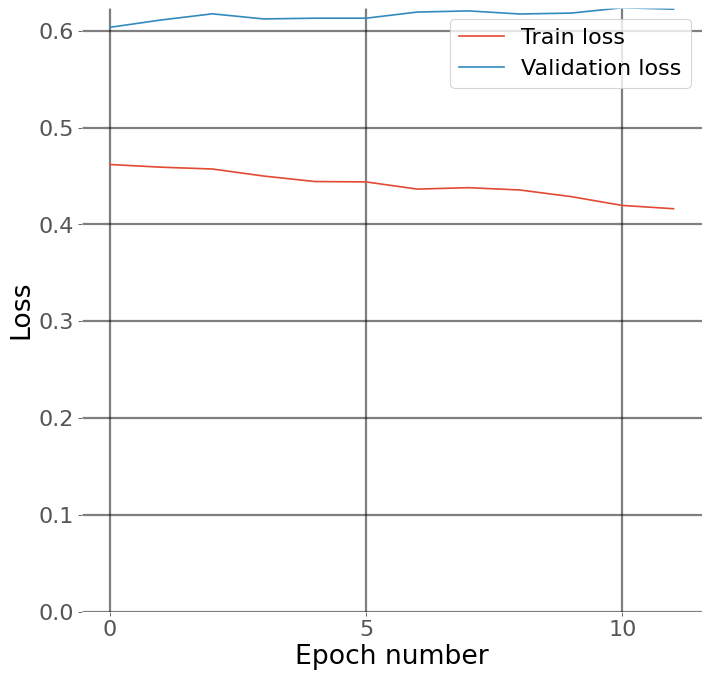

In [43]:
visualize_loss(losses_train, losses_valid)

## Accuracy

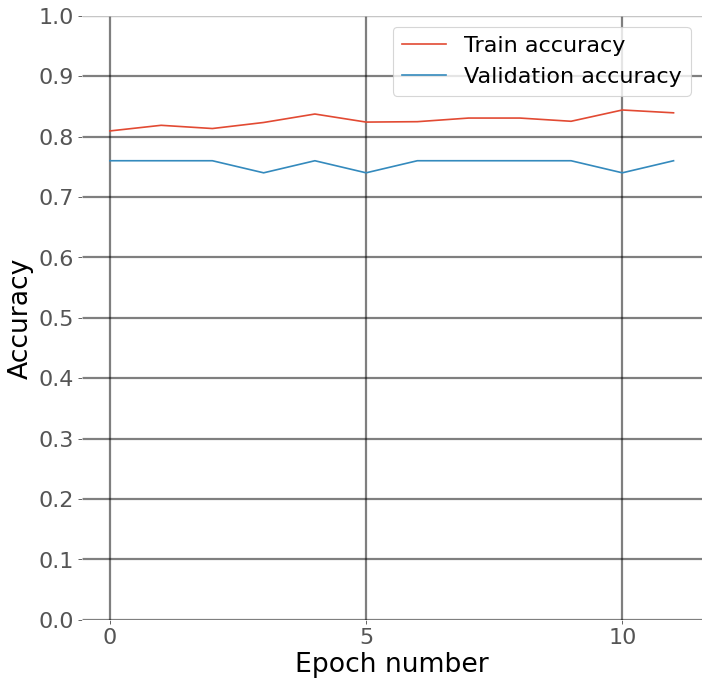

In [44]:
visualize_accuracy(accuracies_train, accuracies_valid)

## Predict on test set

In [21]:
y_test, y_pred_test = evaluate(
    best_bert_model, criterion, dataloader["test"], return_loss=False, threshold=0.5
)

print("Precision:", precision_score(y_true=y_test, y_pred=y_pred_test))
print("Recall:", recall_score(y_true=y_test, y_pred=y_pred_test))
print("F1:", f1_score(y_true=y_test, y_pred=y_pred_test))
print("Accuracy:", accuracy_score(y_true=y_test, y_pred=y_pred_test))

Precision: 0.5964912280701754
Recall: 0.68
F1: 0.6355140186915889
Accuracy: 0.61


## Save best fine-tuned model

In [33]:
model_to_save = (
    best_bert_model.module if hasattr(best_bert_model, "module") else best_bert_model
)
model_to_save.save_pretrained(path + "models/BERT/")
tokenizer.save_pretrained(path + "models/BERT/")

('../models/BERT/tokenizer_config.json',
 '../models/BERT/special_tokens_map.json',
 '../models/BERT/vocab.txt',
 '../models/BERT/added_tokens.json')

## Load best fine-tuned model

In [17]:
bert_model = transformers.BertForSequenceClassification.from_pretrained(
    path + "models/BERT/"
)
tokenizer = transformers.BertTokenizer.from_pretrained(path + "models/BERT/")
best_thr = 0.5

bert_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Define feature extraction and tokenization for fine-tuned BERT

In [18]:
def tokenize_tweet(tweet):
    encoded_dict = tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        padding="max_length",
        max_length=300,
        return_attention_mask=True,
        truncation=True,
        return_tensors="pt",
    )

    input_id = encoded_dict["input_ids"]
    attention_mask = encoded_dict["attention_mask"]

    input_id = input_id.to(device)
    attention_mask = attention_mask.to(device)

    return input_id, attention_mask


def create_emoji_features(emojis):
    vector_sum = np.zeros(300)
    if emojis == emojis:
        for char in set(emoji.get_emoji_regexp().split(str(emojis).strip())):
            if char.strip():
                try:
                    vector = e2v[char]
                    vector_sum += vector
                except:
                    pass
    return vector_sum


def create_features(model, df, options, emoji=True, indicators=True):
    feature_vectors = defaultdict(list)
    with torch.no_grad():
        for index, row in df.iterrows():
            input_id, attention_mask = tokenize_tweet(row["tweet"])
            hidden_states = model(input_id, attention_mask).hidden_states
            for i in range(1, len(options) + 1):
                feature_vector = options[i](hidden_states)
                if emoji:
                    emoji_vec = create_emoji_features(row["emoji"])
                    feature_vector = np.concatenate((feature_vector, emoji_vec), axis=0)
                if indicators:
                    feature_vector = np.concatenate(
                        (
                            feature_vector,
                            np.array([row["rt"], row["url"], row["hashtag"]]),
                        ),
                        axis=0,
                    )
                feature_vectors[i].append(feature_vector)
        for i in range(1, len(options) + 1):
            feature_vectors[i] = np.array(feature_vectors[i])
    return feature_vectors

## Define feature engineering options

In [19]:
def option_1(hidden_states):
    # Get embedding from last state
    return hidden_states[-1][:, 0, :].cpu().data.numpy()[0]


def option_2(hidden_states):
    # Sum embeddings from all hidden states
    return torch.stack(hidden_states[-12:])[:, :, 0, :].sum(0).cpu().data.numpy()[0]


def option_3(hidden_states):
    # Average embeddings from all hidden states
    return torch.stack(hidden_states[-12:])[:, :, 0, :].mean(0).cpu().data.numpy()[0]


def option_4(hidden_states):
    # Sum embeddings from last four hidden states
    return torch.stack(hidden_states[-4:])[:, :, 0, :].sum(0).cpu().data.numpy()[0]


def option_5(hidden_states):
    # Average embeddings from last four hidden states
    return torch.stack(hidden_states[-4:])[:, :, 0, :].mean(0).cpu().data.numpy()[0]


def option_6(hidden_states):
    # Concatenate embeddings from last four hidden states
    return np.concatenate(
        torch.stack(list(reversed(hidden_states[-4:])))[:, :, 0, :]
        .cpu()
        .data.numpy()[:, 0, :]
    )


options = {
    1: option_1,
    2: option_2,
    3: option_3,
    4: option_4,
    5: option_5,
    6: option_6,
}

## Create design matrix and extract labels

In [20]:
X_emoji_indicators = {
    x: create_features(bert_model, original_splits[x], options)
    for x in ["train", "valid", "test"]
}

X_no_emoji_no_indicators = {
    x: create_features(bert_model, original_splits[x], options, False, False)
    for x in ["train", "valid", "test"]
}

X_emoji_no_indicators = {
    x: create_features(bert_model, original_splits[x], options, True, False)
    for x in ["train", "valid", "test"]
}

X_no_emoji_indicators = {
    x: create_features(bert_model, original_splits[x], options, False, True)
    for x in ["train", "valid", "test"]
}

In [21]:
y = {}

for x in ["train", "valid", "test"]:
    labels = original_splits[x].label.tolist()
    y[x] = labels

## Predict functions

In [22]:
def get_author_prediction(predictions, threshold=0.5):
    ones = 0

    for pred in predictions:
        if pred == 1:
            ones += 1

    ones_p = ones / len(predictions)

    if ones_p >= threshold:
        return 1
    else:
        return 0


def my_scorer(y_true, y_pred, scoring="accuracy", threshold=0.5, tweets_per_author=10):
    authors_num = int(len(y_true) / tweets_per_author)
    y_true_author, y_pred_author = [], []
    start = 0
    end = tweets_per_author
    for i in range(authors_num):
        y_true_author.append(list(set(y_true[start:end]))[0])
        y_pred_author.append(get_author_prediction(y_pred[start:end], threshold))
        start += tweets_per_author
        end += tweets_per_author

    if scoring == "accuracy":
        return accuracy_score(y_true_author, y_pred_author)
    elif scoring == "recall":
        return recall_score(y_true_author, y_pred_author)
    elif scoring == "precision":
        return precision_score(y_true_author, y_pred_author)
    else:
        return f1_score(y_true_author, y_pred_author)

## Try out different traditional ML models

In [20]:
def try_model(model, parameters_grid, X, y, thr=0.5):
    for embedding_option in range(1, len(options) + 1):
        print("---------------------------")
        X_train, X_valid, X_test = (
            X["train"][embedding_option],
            X["valid"][embedding_option],
            X["test"][embedding_option],
        )
        y_train, y_valid, y_test = y["train"], y["valid"], y["test"]

        print("Current embedding option:", embedding_option)

        print("Searching for optimal hyperparameters on validation set...")

        param_names = list(parameters_grid.keys())
        params_values = list(parameters_grid.values())

        max_score = 0

        for element in product(*params_values):
            param_dict = dict(zip(param_names, element))
            model = model.set_params(**param_dict)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_valid)
            score = my_scorer(y_valid, y_pred, threshold=thr)
            if score > max_score:
                max_score = score
                best_params = param_dict

        print("Best parameters:", best_params)
        print("Highest score on validation set:", max_score)

        X_all = np.concatenate((X_train, X_valid))
        y_all = y_train + y_valid

        model = model.set_params(**best_params)
        model.fit(X_all, y_all)
        y_pred = model.predict(X_test)

        print("Test set performance:")

        print(
            "Precision:",
            my_scorer(y_true=y_test, y_pred=y_pred, scoring="precision", threshold=thr),
        )
        print(
            "Recall:",
            my_scorer(y_true=y_test, y_pred=y_pred, scoring="recall", threshold=thr),
        )
        print(
            "F1:", my_scorer(y_true=y_test, y_pred=y_pred, scoring="f1", threshold=thr)
        )
        print(
            "Accuracy:",
            my_scorer(y_true=y_test, y_pred=y_pred, scoring="accuracy", threshold=thr),
        )
        print("---------------------------")

### LR

In [21]:
parameters_grid = {
    "C": [2 ** i for i in range(-6, 1)]
    + [2, 3, 4, 5, 6, 7]
    + [2 ** i for i in range(3, 7)],
}

model = LogisticRegression(solver="lbfgs", max_iter=10000)

#### BERT embeddings + emoji + indicators

In [22]:
try_model(model, parameters_grid, X_emoji_indicators, y, thr=0.5)

---------------------------
Current embedding option: 1
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.015625}
Highest score on validation set: 0.7
Test set performance:
Precision: 0.7
Recall: 0.84
F1: 0.7636363636363636
Accuracy: 0.74
---------------------------
---------------------------
Current embedding option: 2
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.015625}
Highest score on validation set: 0.7
Test set performance:
Precision: 0.7258064516129032
Recall: 0.9
F1: 0.8035714285714286
Accuracy: 0.78
---------------------------
---------------------------
Current embedding option: 3
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.03125}
Highest score on validation set: 0.74
Test set performance:
Precision: 0.7192982456140351
Recall: 0.82
F1: 0.7663551401869159
Accuracy: 0.75
---------------------------
---------------------------
Current embedding option: 4
Searching fo

#### Only BERT embeddings

In [23]:
try_model(model, parameters_grid, X_no_emoji_no_indicators, y, thr=0.5)

---------------------------
Current embedding option: 1
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 1}
Highest score on validation set: 0.74
Test set performance:
Precision: 0.7068965517241379
Recall: 0.82
F1: 0.7592592592592593
Accuracy: 0.74
---------------------------
---------------------------
Current embedding option: 2
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.03125}
Highest score on validation set: 0.74
Test set performance:
Precision: 0.7419354838709677
Recall: 0.92
F1: 0.8214285714285714
Accuracy: 0.8
---------------------------
---------------------------
Current embedding option: 3
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.5}
Highest score on validation set: 0.74
Test set performance:
Precision: 0.711864406779661
Recall: 0.84
F1: 0.7706422018348624
Accuracy: 0.75
---------------------------
---------------------------
Current embedding option: 4
Searchin

#### BERT embeddings + emoji

In [24]:
try_model(model, parameters_grid, X_emoji_no_indicators, y, thr=0.5)

---------------------------
Current embedding option: 1
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.015625}
Highest score on validation set: 0.7
Test set performance:
Precision: 0.7
Recall: 0.84
F1: 0.7636363636363636
Accuracy: 0.74
---------------------------
---------------------------
Current embedding option: 2
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.015625}
Highest score on validation set: 0.7
Test set performance:
Precision: 0.7258064516129032
Recall: 0.9
F1: 0.8035714285714286
Accuracy: 0.78
---------------------------
---------------------------
Current embedding option: 3
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.015625}
Highest score on validation set: 0.72
Test set performance:
Precision: 0.6949152542372882
Recall: 0.82
F1: 0.7522935779816514
Accuracy: 0.73
---------------------------
---------------------------
Current embedding option: 4
Searching f

#### BERT embeddings + indicators

In [25]:
try_model(model, parameters_grid, X_no_emoji_indicators, y, thr=0.5)

---------------------------
Current embedding option: 1
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.5}
Highest score on validation set: 0.74
Test set performance:
Precision: 0.7192982456140351
Recall: 0.82
F1: 0.7663551401869159
Accuracy: 0.75
---------------------------
---------------------------
Current embedding option: 2
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.03125}
Highest score on validation set: 0.72
Test set performance:
Precision: 0.7540983606557377
Recall: 0.92
F1: 0.8288288288288288
Accuracy: 0.81
---------------------------
---------------------------
Current embedding option: 3
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.25}
Highest score on validation set: 0.74
Test set performance:
Precision: 0.6833333333333333
Recall: 0.82
F1: 0.7454545454545455
Accuracy: 0.72
---------------------------
---------------------------
Current embedding option: 4
Sea

### SVM

In [26]:
parameters_grid = {
    "C": [2 ** i for i in range(-8, 9)],
    "gamma": [2 ** i for i in range(-8, 9)],
    "kernel": ["rbf"],
}

#### BERT embeddings + emoji + indicators

In [27]:
try_model(SVC(), parameters_grid, X_emoji_indicators, y, thr=0.5)

---------------------------
Current embedding option: 1
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.25, 'gamma': 0.015625, 'kernel': 'rbf'}
Highest score on validation set: 0.8
Test set performance:
Precision: 0.7037037037037037
Recall: 0.76
F1: 0.7307692307692308
Accuracy: 0.72
---------------------------
---------------------------
Current embedding option: 2
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.125, 'gamma': 0.00390625, 'kernel': 'rbf'}
Highest score on validation set: 0.74
Test set performance:
Precision: 0.725
Recall: 0.58
F1: 0.6444444444444445
Accuracy: 0.68
---------------------------
---------------------------
Current embedding option: 3
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.5, 'gamma': 0.015625, 'kernel': 'rbf'}
Highest score on validation set: 0.76
Test set performance:
Precision: 0.7068965517241379
Recall: 0.82
F1: 0.7592592592592593
Accuracy

#### Only BERT embeddings

In [28]:
try_model(SVC(), parameters_grid, X_no_emoji_no_indicators, y, thr=0.5)

---------------------------
Current embedding option: 1
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.015625, 'gamma': 0.0078125, 'kernel': 'rbf'}
Highest score on validation set: 0.78
Test set performance:
Precision: 0.7090909090909091
Recall: 0.78
F1: 0.7428571428571428
Accuracy: 0.73
---------------------------
---------------------------
Current embedding option: 2
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.125, 'gamma': 0.00390625, 'kernel': 'rbf'}
Highest score on validation set: 0.78
Test set performance:
Precision: 0.7317073170731707
Recall: 0.6
F1: 0.6593406593406594
Accuracy: 0.69
---------------------------
---------------------------
Current embedding option: 3
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.00390625, 'gamma': 0.00390625, 'kernel': 'rbf'}
Highest score on validation set: 0.78
Test set performance:
Precision: 0.6666666666666666
Recall: 0.72
F1: 

#### BERT embeddings + emoji

In [29]:
try_model(SVC(), parameters_grid, X_emoji_no_indicators, y, thr=0.5)

---------------------------
Current embedding option: 1
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.25, 'gamma': 0.015625, 'kernel': 'rbf'}
Highest score on validation set: 0.8
Test set performance:
Precision: 0.7037037037037037
Recall: 0.76
F1: 0.7307692307692308
Accuracy: 0.72
---------------------------
---------------------------
Current embedding option: 2
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.125, 'gamma': 0.00390625, 'kernel': 'rbf'}
Highest score on validation set: 0.74
Test set performance:
Precision: 0.725
Recall: 0.58
F1: 0.6444444444444445
Accuracy: 0.68
---------------------------
---------------------------
Current embedding option: 3
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.5, 'gamma': 0.015625, 'kernel': 'rbf'}
Highest score on validation set: 0.76
Test set performance:
Precision: 0.6949152542372882
Recall: 0.82
F1: 0.7522935779816514
Accuracy

#### BERT embeddings + indicators

In [30]:
try_model(SVC(), parameters_grid, X_no_emoji_indicators, y, thr=0.5)

---------------------------
Current embedding option: 1
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.015625, 'gamma': 0.0078125, 'kernel': 'rbf'}
Highest score on validation set: 0.78
Test set performance:
Precision: 0.7090909090909091
Recall: 0.78
F1: 0.7428571428571428
Accuracy: 0.73
---------------------------
---------------------------
Current embedding option: 2
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.125, 'gamma': 0.00390625, 'kernel': 'rbf'}
Highest score on validation set: 0.78
Test set performance:
Precision: 0.7317073170731707
Recall: 0.6
F1: 0.6593406593406594
Accuracy: 0.69
---------------------------
---------------------------
Current embedding option: 3
Searching for optimal hyperparameters on validation set...
Best parameters: {'C': 0.00390625, 'gamma': 0.00390625, 'kernel': 'rbf'}
Highest score on validation set: 0.8
Test set performance:
Precision: 0.660377358490566
Recall: 0.7
F1: 0.6

### RF

In [31]:
parameters_grid = {
    "max_depth": [10, 50, 100, 200, None],
    "n_estimators": [128, 512, 1024, 2048],
}

#### BERT embeddings + emoji + indicators

In [37]:
try_model(
    RandomForestClassifier(bootstrap=False),
    parameters_grid,
    X_emoji_indicators,
    y,
    thr=0.5,
)

---------------------------
Current embedding option: 1
Searching for optimal hyperparameters on validation set...
Best parameters: {'max_depth': 10, 'n_estimators': 128}
Highest score on validation set: 0.76
Test set performance:
Precision: 0.6964285714285714
Recall: 0.78
F1: 0.7358490566037736
Accuracy: 0.72
---------------------------
---------------------------
Current embedding option: 2
Searching for optimal hyperparameters on validation set...
Best parameters: {'max_depth': 10, 'n_estimators': 512}
Highest score on validation set: 0.76
Test set performance:
Precision: 0.6964285714285714
Recall: 0.78
F1: 0.7358490566037736
Accuracy: 0.72
---------------------------
---------------------------
Current embedding option: 3
Searching for optimal hyperparameters on validation set...
Best parameters: {'max_depth': 10, 'n_estimators': 2048}
Highest score on validation set: 0.76
Test set performance:
Precision: 0.6896551724137931
Recall: 0.8
F1: 0.7407407407407408
Accuracy: 0.72
--------

#### Only BERT embeddings

In [33]:
try_model(
    RandomForestClassifier(bootstrap=False),
    parameters_grid,
    X_no_emoji_no_indicators,
    y,
    thr=0.5,
)

---------------------------
Current embedding option: 1
Searching for optimal hyperparameters on validation set...
Best parameters: {'max_depth': 10, 'n_estimators': 128}
Highest score on validation set: 0.78
Test set performance:
Precision: 0.6896551724137931
Recall: 0.8
F1: 0.7407407407407408
Accuracy: 0.72
---------------------------
---------------------------
Current embedding option: 2
Searching for optimal hyperparameters on validation set...
Best parameters: {'max_depth': 10, 'n_estimators': 128}
Highest score on validation set: 0.76
Test set performance:
Precision: 0.6724137931034483
Recall: 0.78
F1: 0.7222222222222223
Accuracy: 0.7
---------------------------
---------------------------
Current embedding option: 3
Searching for optimal hyperparameters on validation set...
Best parameters: {'max_depth': 10, 'n_estimators': 128}
Highest score on validation set: 0.78
Test set performance:
Precision: 0.6949152542372882
Recall: 0.82
F1: 0.7522935779816514
Accuracy: 0.73
----------

#### BERT embeddings + emoji

In [34]:
try_model(
    RandomForestClassifier(bootstrap=False),
    parameters_grid,
    X_emoji_no_indicators,
    y,
    thr=0.5,
)

---------------------------
Current embedding option: 1
Searching for optimal hyperparameters on validation set...
Best parameters: {'max_depth': 10, 'n_estimators': 128}
Highest score on validation set: 0.78
Test set performance:
Precision: 0.711864406779661
Recall: 0.84
F1: 0.7706422018348624
Accuracy: 0.75
---------------------------
---------------------------
Current embedding option: 2
Searching for optimal hyperparameters on validation set...
Best parameters: {'max_depth': 10, 'n_estimators': 512}
Highest score on validation set: 0.76
Test set performance:
Precision: 0.6896551724137931
Recall: 0.8
F1: 0.7407407407407408
Accuracy: 0.72
---------------------------
---------------------------
Current embedding option: 3
Searching for optimal hyperparameters on validation set...
Best parameters: {'max_depth': 10, 'n_estimators': 512}
Highest score on validation set: 0.76
Test set performance:
Precision: 0.6896551724137931
Recall: 0.8
F1: 0.7407407407407408
Accuracy: 0.72
-----------

#### BERT embeddings + indicators

In [35]:
try_model(
    RandomForestClassifier(bootstrap=False),
    parameters_grid,
    X_no_emoji_indicators,
    y,
    thr=0.5,
)

---------------------------
Current embedding option: 1
Searching for optimal hyperparameters on validation set...
Best parameters: {'max_depth': 10, 'n_estimators': 128}
Highest score on validation set: 0.76
Test set performance:
Precision: 0.6964285714285714
Recall: 0.78
F1: 0.7358490566037736
Accuracy: 0.72
---------------------------
---------------------------
Current embedding option: 2
Searching for optimal hyperparameters on validation set...
Best parameters: {'max_depth': 50, 'n_estimators': 128}
Highest score on validation set: 0.78
Test set performance:
Precision: 0.6842105263157895
Recall: 0.78
F1: 0.7289719626168225
Accuracy: 0.71
---------------------------
---------------------------
Current embedding option: 3
Searching for optimal hyperparameters on validation set...
Best parameters: {'max_depth': 200, 'n_estimators': 128}
Highest score on validation set: 0.78
Test set performance:
Precision: 0.7017543859649122
Recall: 0.8
F1: 0.7476635514018691
Accuracy: 0.73
--------

## Save best model

In [23]:
model = LogisticRegression(C=0.03125, solver="lbfgs", max_iter=10000)

X_all = np.concatenate(
    (X_no_emoji_indicators["train"][2], X_no_emoji_indicators["valid"][2])
)
y_all = y["train"] + y["valid"]

model.fit(X_all, y_all)

pickle.dump(model, open(path + "models/lr_771_notebook5_option2.sav", "wb"))

## Save best model predictions

In [35]:
def get_author_prediction(predictions, threshold=0.5):
    ones = 0

    for pred in predictions:
        if pred == 1:
            ones += 1

    ones_p = ones / len(predictions)

    if ones_p >= threshold:
        return 1
    else:
        return 0


def my_scorer(y_true, y_pred, scoring="accuracy", threshold=0.5, tweets_per_author=10):
    authors_num = int(len(y_true) / tweets_per_author)
    y_true_author, y_pred_author = [], []
    start = 0
    end = tweets_per_author
    for i in range(authors_num):
        y_true_author.append(list(set(y_true[start:end]))[0])
        y_pred_author.append(get_author_prediction(y_pred[start:end], threshold))
        start += tweets_per_author
        end += tweets_per_author

    if scoring == "accuracy":
        return (
            accuracy_score(y_true_author, y_pred_author),
            y_true_author,
            y_pred_author,
        )
    elif scoring == "recall":
        return recall_score(y_true_author, y_pred_author), y_true_author, y_pred_author
    elif scoring == "precision":
        return (
            precision_score(y_true_author, y_pred_author),
            y_true_author,
            y_pred_author,
        )
    else:
        return f1_score(y_true_author, y_pred_author), y_true_author, y_pred_author


X_train, X_valid = X_no_emoji_indicators["train"][2], X_no_emoji_indicators["valid"][2]

y_train, y_valid = y["train"], y["valid"]

X_test = create_features(
    bert_model, original_splits["test"].sort_values("author_id"), options, False, True
)[2]
y_test = original_splits["test"].sort_values("author_id").label.values

model = LogisticRegression(C=0.03125, solver="lbfgs", max_iter=10000)

X_all = np.concatenate((X_train, X_valid))
y_all = y_train + y_valid

model.fit(X_all, y_all)

score, y_test_author, y_pred_author = my_scorer(y_test, model.predict(X_test).tolist())

with open(path + "predictions/proposed_true.npy", "wb") as f:
    np.save(f, np.array(y_test_author))

with open(path + "predictions/proposed_pred.npy", "wb") as f:
    np.save(f, np.array(y_pred_author))